In [1]:
# change working directory to the root of the project
import os
os.chdir('..')

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import pyprotoevo

sim_name = 'aether-alakazam-et'

In [4]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [60]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

In [7]:
genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 3 == 0
}

In [61]:
all_stats = set(stat for time_stamp in stats for stat in stats[time_stamp]['stats'])

In [62]:
black_list = ['Node', 'Organelle', 'Log', 'Molecule']
basic_stats = [
    stat for stat in all_stats
    if all(x not in stat for x in black_list)
]
', '.join(basic_stats)

'Num Spikes Count, Plant Digestion Rate Mean, Died from running out of health, Fixtures, Meat Pellets, Being Engulfed Mean, Died from old age, Construction Mass Mean, Died from cytokinesis, Num Engulfed Mean, Num Spikes Mean, Physics Step Time, Construction Mass Limit Mean, Protozoa Created, Proxies, GRN Size Mean, Died from overcrowding, Max Protozoa Generation, Time Elapsed, Num Cell Bindings Count, Died from being healed to death?..., Joints, Num Mutations Mean, Plants Created, Meat Digestion Rate Mean, Died from suffocation, GRN Depth Mean, Total Mass Mean, Size Mean, Contacts, Died from the void, Meat Created, Max Plant Generation, Plant to Digest Count, Plants, Has Mated Mean, Sleeping, Repair Rate Mean, Speed Mean, Split Radius Mean, Plant to Digest Mean, Generation Mean, Meat to Digest Count, Meat to Digest Mean, Bodies, Mean Mutation Chance Mean, Num Cell Bindings Mean, Num Engulfed Count, Died from being eaten, Protozoa, Growth Rate Mean, Death Rate Mean, Died from exceeding 

In [63]:
stat_types = {
    stat: record['unit']['units']
    for time_stamp in stats.keys()
    for stat, record in stats[time_stamp]['stats'].items()
    if record['unit'] is not None
}

In [64]:
def unit_to_string(unit: dict) -> str:
    '''
    Convert a unit dictionary to a string.
    For instance, {'MASS': 1, 'TIME': -1} becomes 'µg/s'.
    Possible base units are:
    - MASS: converted to micrograms (1e-6)
    - DISTANCE: converted to micrometers (1e-6)
    - TIME: converted to seconds (1)
    - ENERGY: converted to joules (1)
    - COUNT: converted to number (1)
    - ANGLE: converted to radians (1)
    - PERCENTAGE: converted to percentage (1)
    '''
    units = {
        'MASS': 'µg',
        'DISTANCE': 'µm',
        'TIME': 's',
        'ENERGY': 'J',
        'COUNT': '',
        'ANGLE': 'rad',
        'PERCENTAGE': '%'
    }
    return ''.join([
        units[key] + ('' if val == 1 else '^{' + str(val) + '}')
        for key, val in unit.items()
    ])

In [65]:
stat_type_strs = {
    stat: unit_to_string(unit)
    for stat, unit in stat_types.items()
}

In [66]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']

In [67]:
from datetime import datetime

In [68]:
generation_df = pd.DataFrame([
    {
        'Time': datetime(*map(int, time_stamp.split('-'))),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in stats.items()
]);
generation_df['Wall Time'] = generation_df['Time'] - generation_df['Time'].min()
generation_df['Next Time Stamp'] = generation_df['Time Stamp'].shift(-1)
generation_df.head()

,Time,Time Stamp,Generation,Wall Time,Next Time Stamp
0,2023-03-03 21:23:09,2023-03-03-21-23-09,1,0 days 00:00:00,2023-03-03-21-29-23
1,2023-03-03 21:29:23,2023-03-03-21-29-23,3,0 days 00:06:14,2023-03-03-21-39-19
2,2023-03-03 21:39:19,2023-03-03-21-39-19,3,0 days 00:16:10,2023-03-03-21-49-38
3,2023-03-03 21:49:38,2023-03-03-21-49-38,6,0 days 00:26:29,2023-03-03-21-59-38
4,2023-03-03 21:59:38,2023-03-03-21-59-38,7,0 days 00:36:29,2023-03-03-22-09-20


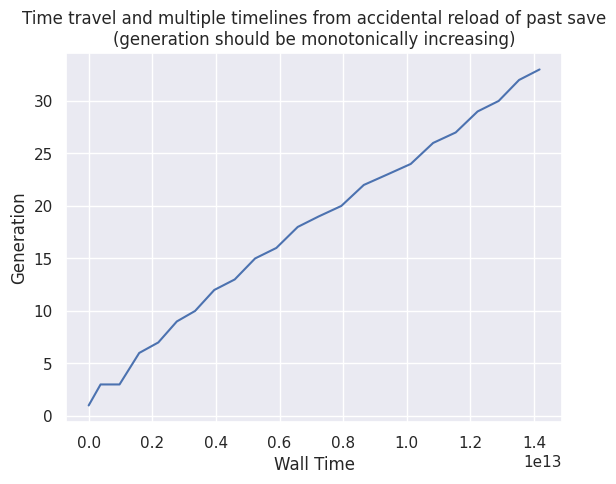

In [69]:
plt.title('Time travel and multiple timelines from accidental reload of past save\n(generation should be monotonically increasing)')
sns.lineplot(data=generation_df, x='Wall Time', y='Generation');

In [70]:
generation_df = generation_df.sort_values('Time Stamp')
records = generation_df.to_records()


def are_all_future_records_of_higher_generation(record):
    return all(
        record['Generation'] < records[i]['Generation']
        for i in range(record['index'] + 1, len(records))
    )


cleaned_stats = {
    (time_stamp := record['Time Stamp']) : stats[time_stamp]
    for record in records
    if are_all_future_records_of_higher_generation(record)
}

In [71]:
def get_datetime(time_stamp: str) -> datetime:
    return datetime(*map(int, time_stamp.split('-')))

In [72]:
generation_df_cleaned = pd.DataFrame([
    {
        'Time': get_datetime(time_stamp),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in cleaned_stats.items()
]);
generation_df_cleaned['Wall Time'] = generation_df_cleaned['Time'] - generation_df_cleaned['Time'].min()

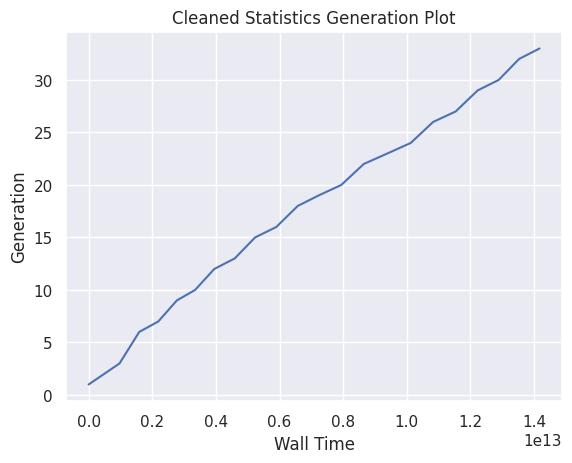

In [73]:
plt.title('Cleaned Statistics Generation Plot')
sns.lineplot(data=generation_df_cleaned, x='Wall Time', y='Generation');

In [74]:
stats = cleaned_stats

In [75]:
stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])
stats_df.fillna(0, inplace=True)
stats_df.replace(to_replace='NaN', value=0, inplace=True)
stats_df.head()

,Plant Digestion Rate Mean,Fixtures,Meat Pellets,Being Engulfed Mean,Construction Mass Mean,Physics Step Time,Construction Mass Limit Mean,Protozoa Created,Proxies,GRN Size Mean,...,Meat Created,Plant to Digest Mean,Meat to Digest Count,Meat to Digest Mean,Died from being eaten,Died from murder,Num Engulfed Mean,Num Engulfed Count,Plant to Digest Count,Died from being healed to death?...
0,1.246940,2695,0,0.0,1.000000e-02,0.0,0.001484,500,2695,40.472000,...,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,1.372647,4686,125,0.0,0.000000e+00,0.0,0.001294,710,4686,41.116279,...,2062.0,0.000032,36.0,5.078189e-06,131.0,91.0,0.0,0.0,0.0,0.0
2,1.545237,4676,0,0.0,3.443831e-41,0.0,0.000991,782,4676,41.375000,...,2191.0,0.000031,11.0,2.070955e-13,223.0,109.0,1.0,1.0,0.0,0.0
3,1.588243,4672,30,0.0,1.403279e-09,0.0,0.001106,848,4672,41.676471,...,2350.0,0.000033,24.0,2.536629e-06,340.0,131.0,2.0,1.0,0.0,0.0
4,1.748025,4653,34,0.0,1.067693e-10,0.0,0.001076,936,4653,41.734940,...,2539.0,0.000024,10.0,3.517190e-05,482.0,143.0,1.0,1.0,0.0,0.0


<AxesSubplot: xlabel='Generation Mean', ylabel='Protozoa'>

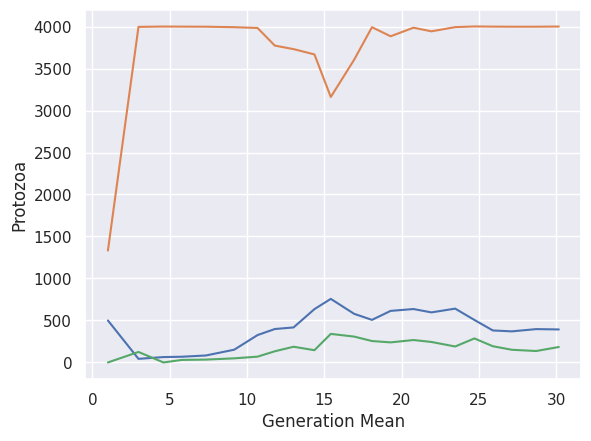

In [76]:
sns.lineplot(data=stats_df, x='Generation Mean', y='Protozoa')
sns.lineplot(data=stats_df, x='Generation Mean', y='Plants')
sns.lineplot(data=stats_df, x='Generation Mean', y='Meat Pellets')

In [77]:
stats_df.columns

Index(['Plant Digestion Rate Mean', 'Fixtures', 'Meat Pellets',
       'Being Engulfed Mean', 'Construction Mass Mean', 'Physics Step Time',
       'Construction Mass Limit Mean', 'Protozoa Created', 'Proxies',
       'GRN Size Mean', 'Max Protozoa Generation', 'Time Elapsed', 'Joints',
       'Num Mutations Mean', 'Plants Created', 'Meat Digestion Rate Mean',
       'GRN Depth Mean', 'Total Mass Mean', 'Size Mean', 'Contacts',
       'Max Plant Generation', 'Plants', 'Has Mated Mean', 'Sleeping',
       'Repair Rate Mean', 'Speed Mean', 'Split Radius Mean',
       'Generation Mean', 'Bodies', 'Mean Mutation Chance Mean', 'Protozoa',
       'Growth Rate Mean', 'Death Rate Mean',
       'Died from exceeding environment capacity', 'Herbivore Factor Mean',
       'Age Mean', 'Health Mean', 'Crossover Events', 'Available Energy Mean',
       'Num Spikes Count', 'Died from running out of health',
       'Died from old age', 'Died from cytokinesis', 'Num Spikes Mean',
       'Died from overc

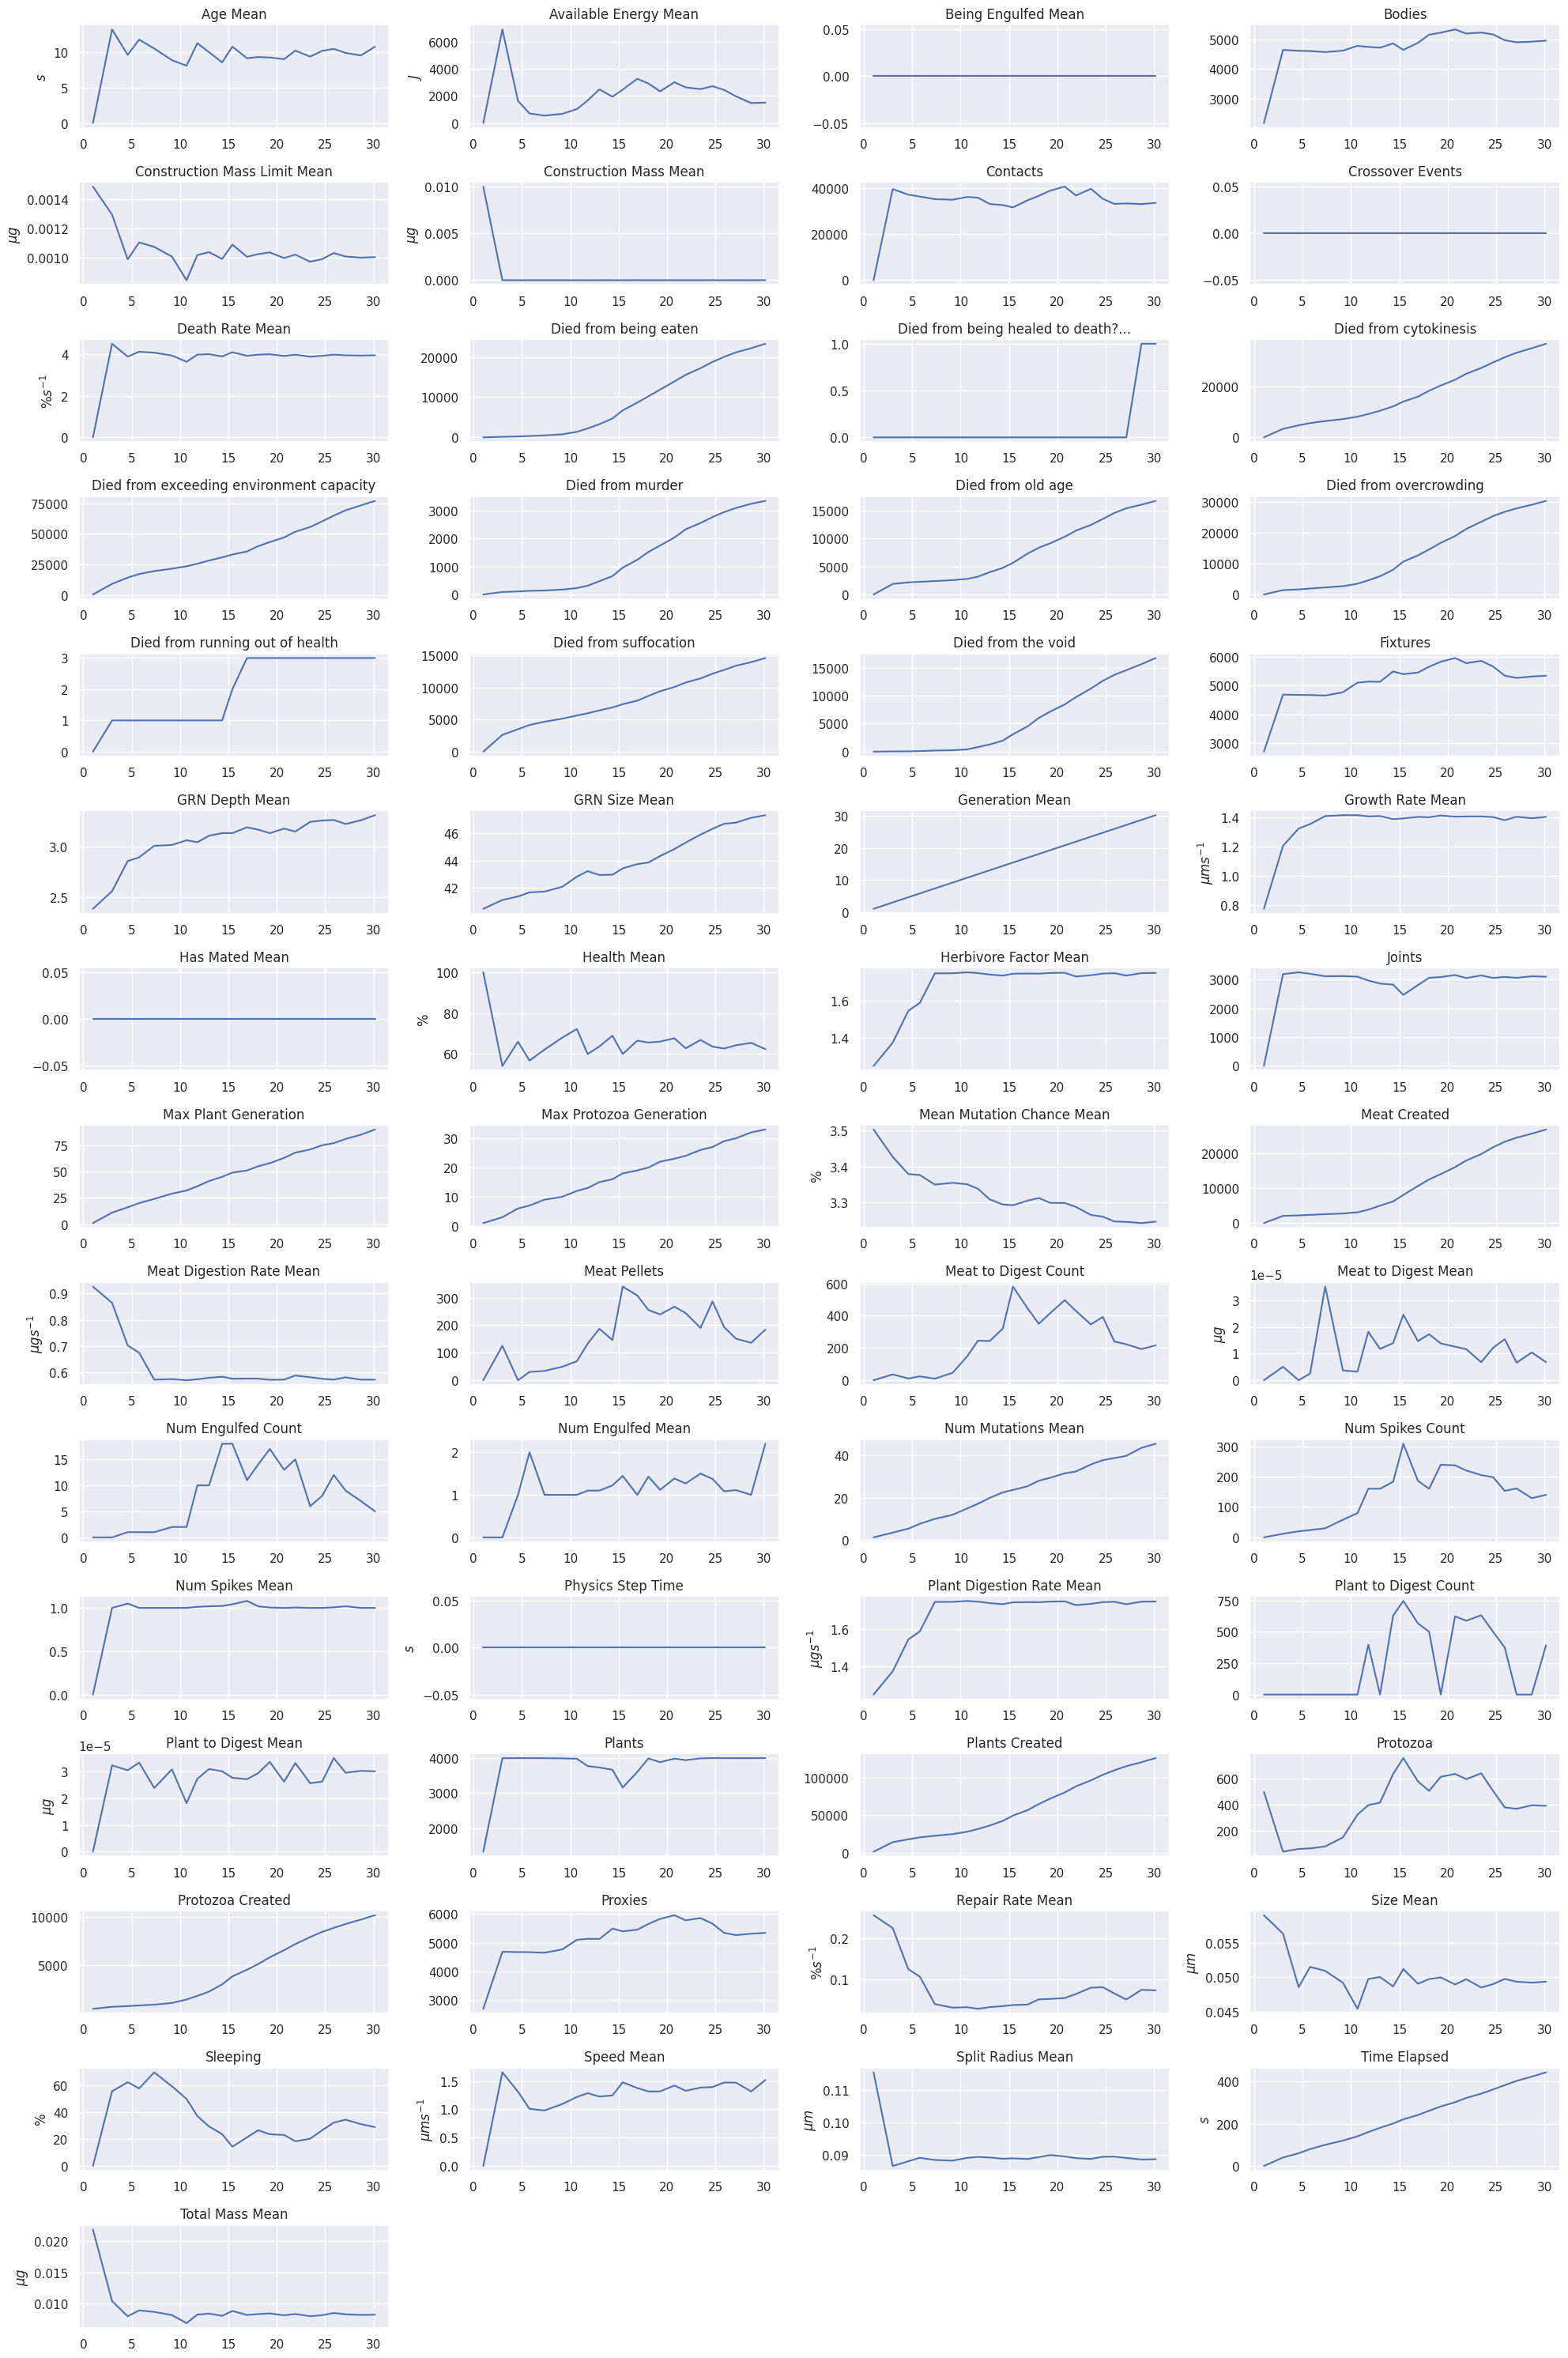

In [78]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
rows = int(np.ceil(stats_df.columns.size / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stats_df.columns)):
    if stat is not None:
        sns.lineplot(data=stats_df, x='Generation Mean', y=stat, ax=ax)
        ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['frequency'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
    if time in stats
])

In [27]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,frequency
0,-9223346552413402282,1,2023-03-03-21-23-09,1.000000,500,0.002000
1,3049545419674175314,1,2023-03-03-21-23-09,1.000000,500,0.002000
2,3052767476432128545,1,2023-03-03-21-23-09,1.000000,500,0.002000
3,3051462027906531769,1,2023-03-03-21-23-09,1.000000,500,0.002000
4,3050905834083600532,1,2023-03-03-21-23-09,1.000000,500,0.002000
...,...,...,...,...,...,...
1189,-496607107585062870,1,2023-03-04-00-35-26,24.705534,506,0.001976
1190,-490263970538568757,1,2023-03-04-00-35-26,24.705534,506,0.001976
1191,-455922280386179769,1,2023-03-04-00-35-26,24.705534,506,0.001976
1192,-454442562511879305,1,2023-03-04-00-35-26,24.705534,506,0.001976


In [49]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(200))\
    .reset_index()
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,3508351925365458295,69593.142857,73.65251,47207.571429,0.143657
1,-6971453805710719399,69593.142857,73.65251,47207.571429,0.143657
2,-4374179944481340913,69593.142857,73.65251,47207.571429,0.143657
3,5762561832540588950,69593.142857,73.65251,47207.571429,0.143657
4,-6864148590486270999,69593.142857,73.65251,47207.571429,0.143657


In [50]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='frequency')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


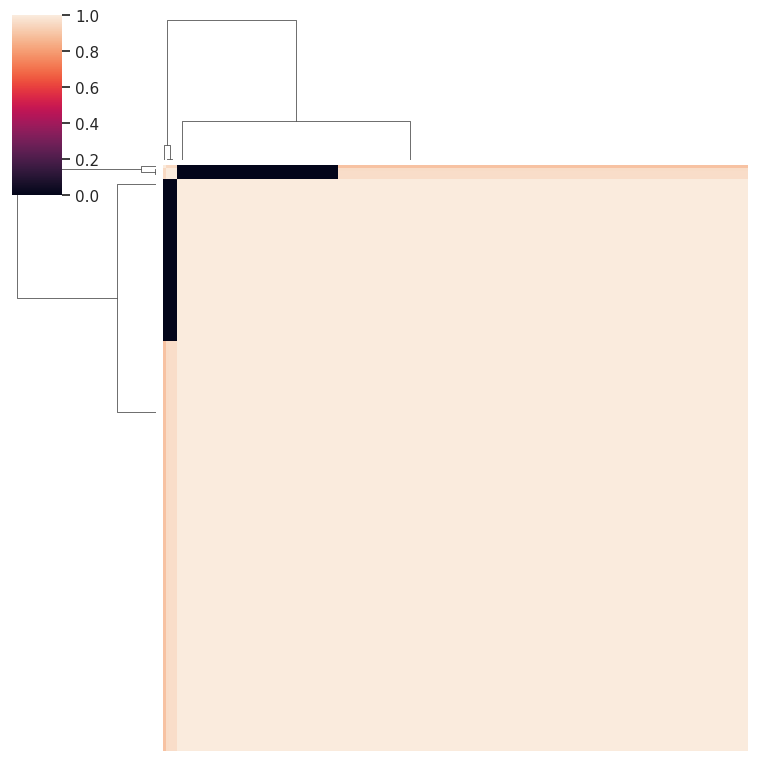

In [51]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [52]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.1 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters_ids = np.unique(idx)
clusters = {
    cluster_id: [signature for signature, cluster in signature_clusters.items() if cluster == cluster_id]
    for cluster_id in clusters_ids
}
clusters_ids

array([1, 2, 3, 4], dtype=int32)

In [53]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var frequency'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

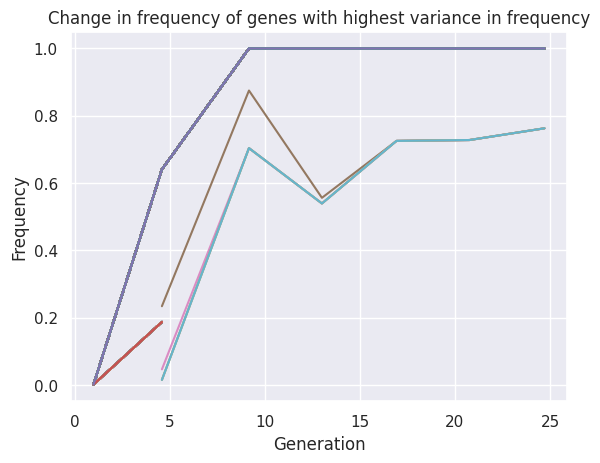

In [54]:
for gene in high_var_genes_df['signature'].unique():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

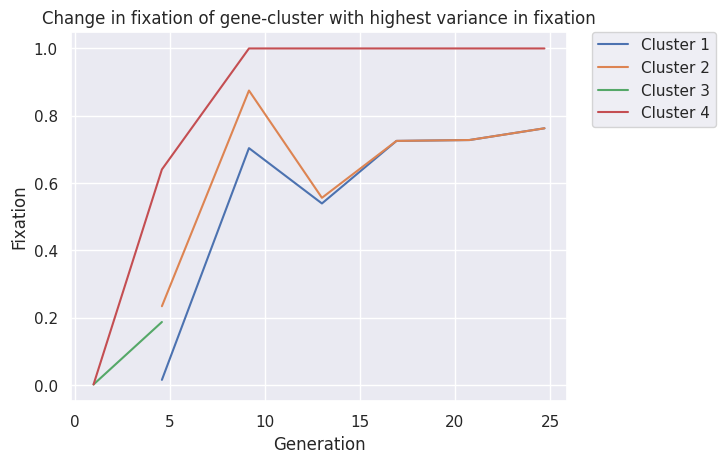

In [55]:
for cluster_id, gene in cluster_prototypes.items():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'], label=f'Cluster {cluster_id}')
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
# legend outside of plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [56]:
last_generation_time_stamp = max(genomes.keys(), key=get_datetime)
last_generation_time_stamp

last_generation_signatures = set([
    gene['signature']
    for genome in genomes[last_generation_time_stamp]
    for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
])

survived_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(last_generation_signatures)]
survived_genes_df.head()

,signature,count,time,generation,num_protozoa,frequency
534,3095237171122883467,1,2023-03-03-21-23-09,1.0,500,0.002
863,2983291900990735629,1,2023-03-03-21-23-09,1.0,500,0.002
1844,3163734236189969305,1,2023-03-03-21-23-09,1.0,500,0.002
2609,2576155609635963269,1,2023-03-03-21-23-09,1.0,500,0.002
3953,2615900708699718213,1,2023-03-03-21-23-09,1.0,500,0.002


In [57]:
survived_variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
survived_variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,3508351925365458295,69593.142857,73.65251,47207.571429,0.143657
1,-6971453805710719399,69593.142857,73.65251,47207.571429,0.143657
2,-4374179944481340913,69593.142857,73.65251,47207.571429,0.143657
3,5762561832540588950,69593.142857,73.65251,47207.571429,0.143657
4,-6864148590486270999,69593.142857,73.65251,47207.571429,0.143657


In [58]:
survived_high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(survived_variance_df['signature'])]

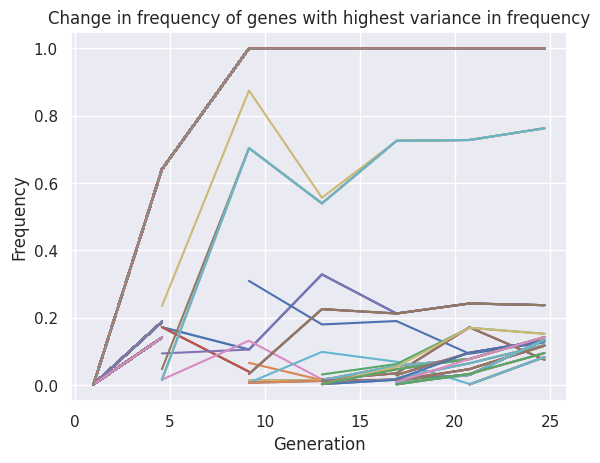

In [59]:
for gene in survived_high_var_genes_df['signature'].unique():
    gene_ts = survived_high_var_genes_df[survived_high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

In [142]:
variance_df['cluster id'] = variance_df['signature'].map(signature_clusters)
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency,cluster id
0,-8469246420843936082,128100.000000,1323.337666,75927.777778,0.115012,5
1,2074060241260660010,42405.238095,857.660999,65812.476190,0.112626,1
2,5696769961235926407,42405.238095,857.660999,65812.476190,0.112626,1
3,-4194016379000828326,42405.238095,857.660999,65812.476190,0.112626,1
4,-8591072557852766345,123117.250000,1323.337666,75927.777778,0.094127,5


In [34]:
variance_df.groupby('cluster id').var()

,signature,var count,var generation,var num_protozoa,var frequency
cluster id,,,,,
1,4.484679e+37,0.000000e+00,0.00000,0.000000e+00,0.000000
2,2.864903e+37,2.266721e+06,138.07092,1.288129e+07,0.000014
